# Section II. MODELING
    
# Chapter 6. Inverse Kinematics

As opposed to forward kinematics, which computes the workspace
coordinates of the robot given a configuration as input, inverse
kinematics (IK) is essentially the reverse operation: computing
configuration(s) to reach a desired workspace coordinate. This operation
is essential to many robotics tasks, like moving a tool along a
specified path, manipulating objects, and observing scenes from a
desired vantage point. Because it is so important, inverse kinematics
has been studied extensively, with many techniques available to solve it
quickly and (relatively) reliably.

However, unlike forward kinematics, inverse kinematics cannot be solved
in a closed-form expression (in general). We shall see there may be no
solutions, multiple solutions, or even an infinite number of solutions
to an IK problem. As a result, the subtleties of IK must be understood
in order to apply it effectively in practice. This chapter will discuss
several general issues regarding IK, including the notions of task
space, redundancy, and singularities. Both analytical and numerical
methods to solve inverse kinematics will be presented.


General discussion
------------------

If we express the coordinates of some point $X$ attached to the robot as
a vector $\mathbf{x}$, forward kinematics allows us to compute a map
$\mathbf{x}(\mathbf{q}) \equiv f(\mathbf{q})$ where $\mathbf{q}$ is the robot's
configuration. Note that this map is vector-valued. The goal of IK is to
produce an inverse of the map $f$, or more specifically, given a desired
value $\mathbf{x}_D$, calculate one or more solutions $\mathbf{q}$ such that
$\mathbf{x}_D = \mathbf{x}(\mathbf{q}) \equiv f(\mathbf{q})$ hold. We also say that
$\mathbf{x}(\mathbf{q}) - \mathbf{x}_D = 0$ is the *constraint equation* that $\mathbf{q}$
must meet.

************

![fig:2RIK](https://github.com/krishauser/RoboticSystemsBook/blob/master/figures/modeling/ik_2R.png?raw=1)

<div class="figcaption"><a name="fig:2RIK">Figure 1</a>.
Illustrating the IK problem for a 2R planar manipulator. (a) The goal
is to find one or more configurations $\mathbf{q}$ so that the end effector
position $\mathbf{x}(\mathbf{q})$ is matched to a target position $\mathbf{x}_D$. IK
problems may have more than one solution, and in this case there are two
solutions (b,c) given by $(q_1^A,q_2^A)$ and
$(q_1^B,q_2^B)$.</div>

************

For instance, suppose $X$ is a point on link $N$ and has local
coordinates $\mathbf{x}_N$ (relative to link $N$). After the robot moves,
link $N$ has coordinate frame $T_N(\mathbf{q})$ relative to the world frame.
Hence, $X$ has world coordinates $$\mathbf{x}(\mathbf{q}) = T_N(\mathbf{q}) \mathbf{x}_N.$$

Given $\mathbf{x}_D$ specifying some desired coordinates of $X$ in the world
frame, IK would compute some $\mathbf{q}$ so that
$T_N(\mathbf{q}) \mathbf{x}_N = \mathbf{x}_D$. Depending on the value of $\mathbf{x}_D$ and
the kinematic structure of the robot, there may be no solution, such as
when the desired point is out of reach. There may also be multiple
solutions, as illustrated in
[Fig. 1](#fig:2RIK). A third case is when infinite solutions may
occur, such as when the robot is *redundant*, which means that it
possesses more degrees of freedom than the dimension of the workspace.


### Nonlinear mapping between C-space and workspace

The big challenge in inverse kinematics is that the mapping from configuration space to workspace is *nonlinear*.  This means that straight lines in the joint space map to curves in the workspace, and vice versa.   In other words, the direction of motion in workspace changes continuously as the configuration moves. The plots below show some examples for the 2R robot with unit lengths.  

The significance of this is that we cannot simply use the tools of linear algebra to solve IK problems.  We will need to use more sophisticated geometric and mathematical manipulations in order to find solutions.  Moreover, whereas the solution to linear systems of equations may be unique points or linear subspaces of solutions, the solution to nonlinear equations can be multiple points, or even nonlinear manifolds.  


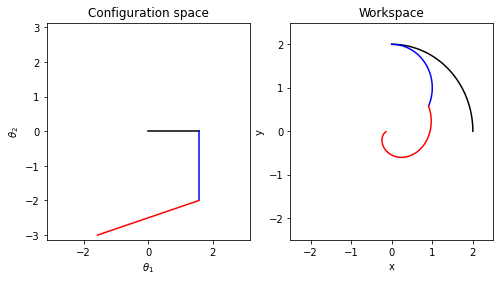

In [7]:
#@title
#Code for generating the figures below
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

fig = plt.figure(figsize=(8,4))
axjoint = fig.add_subplot(121)
axwork = fig.add_subplot(122)

L1,L2=1,1
def fk(q1,q2):
    c1 = np.cos(q1)
    s1 = np.sin(q1)
    c12 = np.cos(q1+q2)
    s12 = np.sin(q1+q2)
    return (c1*L1+c12*L2,s1*L1+s12*L2)

def plotlines(qa,qb,divs=40,**kwargs):
    q1 = np.linspace(qa[0],qb[0],divs)
    q2 = np.linspace(qa[1],qb[1],divs)
    x,y = fk(q1,q2)
    axjoint.plot(q1,q2,**kwargs)
    axwork.plot(x,y,**kwargs)

axjoint.set_xlim(-math.pi,math.pi)
axjoint.set_ylim(-math.pi,math.pi)
axjoint.set_title("Configuration space")
axjoint.set_xlabel(r'$\theta_1$')
axjoint.set_ylabel(r'$\theta_2$')
axwork.set_xlim(-2.5,2.5)
axwork.set_ylim(-2.5,2.5)
axwork.set_title("Workspace")
axwork.set_xlabel('x')
axwork.set_ylabel('y')
plotlines((0,0),(math.pi/2,0),color='k')
plotlines((math.pi/2,0),(math.pi/2,-2),color='b')
plotlines((math.pi/2,-2),(-math.pi/2,-3),color='r')
plt.show()

### Task space

The coordinates $\mathbf{x}$ are known as *task coordinates* which define the
robot's intended goal that it should perform in Cartesian space. In the
example above, the task consisted only of Cartesian position, but it
could generalize to also include orientation of the final link through a
different choice of $f$. To define a combination of position and
orientation goal, we would append some rotation parameterization like
Euler angles to $\mathbf{x}$, and define the forward kinematic map:

$$\mathbf{x} \equiv \begin{bmatrix}
  \mathbf{x}_p \\
  \mathbf{x}_o
\end{bmatrix}=f(\mathbf{q}) \equiv
 \begin{bmatrix}
   T_N(\mathbf{q})\mathbf{x}_N \\
   R_{ea}^{-1}(R_N(\mathbf{q}))
 \end{bmatrix}$$ 


where $R_N(\mathbf{q})$ is the 3x3 rotation matrix of the $N$'th link, and
$R_{ea}^{-1}(R)$ computes the euler angle representation of the rotation
matrix $R$ (according to some chosen convention). Here $\mathbf{x}_p$ is the
position of $X$ and $\mathbf{x}_o$ is the Euler angle representation of the
orientation of the link on which it resides.

It is also possible to define more exotic task spaces to accomplish
different goals. Suppose for example that $X$ is a point in the middle
of the robot's gripper, and it is supposed to lift a cup of liquid
without tipping it. If we define a local direction $\mathbf{d}_N$ as an "up"
direction perpendicular to the gripper opening direction, and $\mathbf{z}$
being the up direction in world coordinates, then we can specify a
directional task constraint:
$$\mathbf{d}(\mathbf{q}) - \mathbf{z} = R_N (\mathbf{q}) \mathbf{d}_N - \mathbf{z} = 0$$ where
$\mathbf{d}(\mathbf{q})$ is the direction of the desired "up" vector attached to
the gripper, but expressed in world coordinates.

In general, the task space may consist of any number of position and
orientation constraints on the robot. For example, for a $k$-legged
robot, up to $k$ leg positions and orientation may be constrained to be
fixed while the body moves. In any of these cases we can still express
the constraint as a vector equation $\mathbf{x}(\mathbf{q}) - \mathbf{x}_D = 0$ by
stacking each individual constraint into a larger vector.


### Analytical vs numerical IK

There exist two general approaches for solving IK problems. In the
*analytical* approach, the equation $\mathbf{x}_D = f(\mathbf{q})$ is
mathematically inverted into a closed-form expression through symbolic
manipulations. In the *numerical approach*, we are given an initial
guess $\mathbf{q}_0$ and then calculate a sequence of configurations
$\mathbf{q}_0,\mathbf{q}_1,\mathbf{q}_2,\ldots$ such that the error
$\| f(\mathbf{q}) - \mathbf{x}_D \|$ approaches 0. This section will focus on
analytical methods.

The advantages of the analytical method include:

-   Computes all IK solutions, and determines whether no solution
    exists.

-   Once the equations are derived, solutions are very fast to compute.

-   No need to define solution parameters or initial guesses $\mathbf{q}_0$

Disadvantages of the analytical method include:

-   Often difficult or tedious to derive.

-   Must be derived independently for robots with different kinematic
    structures.

-   Only applicable to nonredundant robots (\# DOFs = \# of task space
    dimensions).


### Choosing from a set of solutions: incorporating extra constraints

It is important to note that when multiple solutions exist, neither IK
approach specifies which solution is "best." Also, it is important to
note that many of the solutions produced by IK techniques may be
infeasible for a robot to undertake. For example, IK solutions may
exceed joint limits, cause the robot to self-collide, or cause the robot
to collide with environmental obstacles. In fact, the notion of "best"
or "feasible" must be defined by some criterion external to the choice
of task. The requirement of producing high-quality solutions can be
considered as a *soft constraint*, while strict requirements are
considered *hard constraints*.

Soft constraints can be expressed as seeking an IK solution that
minimizes some scalar function $g(\mathbf{q})$. To handle soft constraints,
in the analytical case where multiple solutions exist, we may simply
loop through all solutions; in the numerical case, there are some
solution techniques that (locally) minimize $g(\mathbf{q})$ among possible
solutions. To handle hard constraints in the analytical solution case,
they may be checked after solving for all solutions. In the numerical
case, it is preferable to use solution techniques that enforce these
additional constraints.

Throughout this chapter, however, additional constraints will not be
considered unless otherwise specified.

### Counting solutions

For *almost all* task parameters $\mathbf{x}$ (in a sense to be made more
precise later) and "usual" kinematic structures, it is possible to coarsely
determine the number of solutions simply by examining the number of DOFs
of the robot and the number of constraints. Letting $n$ be the number of
DOFs and $m$ be the number of task constraints, we have the following
general rules:

-   If $n < m$, then no solutions to $\mathbf{x} = f(\mathbf{q})$ exist.
    (Overconstrained system of equations.)

-   If $n = m$, then a finite number of solutions exist.

-   If $n > m$, then either no solutions or an infinite number of
    solutions exist. (Underconstrained system of equations.)

In the overconstrained case, there is insufficient flexibility in the
choice of $\mathbf{q}$ to attain arbitrary values of $\mathbf{x}$. In the
underconstrained case, the robot is also called *redundant*. When the
task exceeds the reach of the robot, there is no solution, but whenever
a solution exists, there is a *continuum* of solutions that attain the
same task. In fact, the solution set in general will have intrinsic
dimension $n-m$ -- that is there will be $n-m$ independent directions of
flexibility in configuration space while maintaining the task as fixed.
It is often the case in redundant robots that it is difficult to
characterize all of the solutions for a given task, although we shall
describe methods for doing so when describing parallel robots.


### Singularities

The counting rules hold almost everywhere except for certain unstable
settings of the parameter $\mathbf{x}$, which are known as *singularities*.
We have already discussed singularities in the context of 3D rotations,
where a rotation may have multiple representations. In nonredundant IK,
a singularity occurs when the task has an infinite number of solutions,
or precisely one solution. In redundant IK, a singularity is observed as
a change in the intrinsic dimensionality of the solution set.

Singularities are *unstable* in the sense that any open neighborhood
containing a singular task point $\mathbf{x}$ will have different numbers of
solutions. In other words, if $\mathbf{x}$ were perturbed slightly, the
number of solutions will almost certainly change. Non-singular points do
not have this problem: for a non-singular point $\mathbf{x}$, there will
exist an open neighborhood of $\mathbf{x}$ for which the number of solutions
remains constant.

In practical terms, singularities usually avoided during IK for a number
of reasons: as a singularity is approached in task space, the
solution configurations change increasingly rapidly, and the solution
set may change size, making it challenging to produce smooth movements.
There is a straightforward way of computing whether a configuration is
at a singularity via a condition about the task's *Jacobian matrix*.
This will be discussed in the [section on Jacobians](#The-Jacobian-matrix). 


Analytical IK in 2D
-------------------

Let us begin by deriving analytical solutions for most common planar
robots.


### 2R manipulator

************

![fig:2RIKb](https://github.com/krishauser/RoboticSystemsBook/blob/master/figures/modeling/ik_2Rb.png?raw=1)

<div class="figcaption"><a name="fig:2RIKb">Figure 2</a>
The key steps for solving the planar 2R IK problem. (a) Determine a
value for $q_2$ that puts the end effector point on the circle centered
on the origin with radius equal to the distance between the origin and
the target point. Here there are 2 solutions. Then, determine the values of $q_1$
that the end effector is rotated onto the target, with $q_2$ fixed to
its first (b) and second (c)
solutions.</div>

************

Consider a 2R manipulator with the first joint located at the origin,
and at the reference configuration the second joint is located $L_1$
distance away along the $x$ axis. The end effector is located $L_2$
distance away from the second joint along the $x$ axis.

With this definition, the forward kinematics equations in the previous
chapter show that the world coordinates of the end effector at
configuration $\mathbf{q} = (q_1,q_2)$ are given by: $$\begin{split}
\mathbf{x}(\mathbf{q}) &= R(q_1)\left(R(q_2) \begin{bmatrix} L_2 \\ 0 \end{bmatrix} + \begin{bmatrix} L_1 \\ 0 \end{bmatrix} \right) \\
 & = R(q_1) \begin{bmatrix}L_1 + c_2 L_2 \\ s_2 L_2 \end{bmatrix} = \begin{bmatrix} c_1(L_1 + c_2 L_2) - s_1 s_2 L_2 \\ s_1(L_1 + c_2 L_2) + c_1 s_2 L_2 \end{bmatrix}
\end{split}$$ where $c_i = \cos q_i$ and $s_i = \sin q_i$, for
$i = 1,2$.

Suppose we wish to move this $\mathbf{x}$ to the target point $\mathbf{x}_D$.
Thinking geometrically, we observe that the only joint controlling the
norm $\| \mathbf{x}(\mathbf{q}) \|$ (i.e., the distance from the end effector to
the origin) is $q_2$. See
[Fig. 2](#fig:2RIKb)(a) for an illustration. As a result,
$\| \mathbf{x}(q_1,q_2) \| = \| \mathbf{x}(0,q_2) \|$ which results in the
simplified calculation:
$$\| \mathbf{x}(q_1,q_2) \| = \sqrt{(L_1 + c_2 L_2)^2 + (s_2 L_2)^2}.$$ Since
this norm must match the norm of $\mathbf{x}_D$, we require:
$$\| \mathbf{x}_D \|^2 = (L_1 + c_2 L_2)^2 + (s_2 L_2)^2 = L_1^2 + 2 c_2 L_1 L_2 + c_2^2 L_2^2 + s_2^2 L_2^2 = L_1^2 + 2 c_2 L_1 L_2 + L_2^2$$
where in the last equality we've used the fact that $c_i^2 + s_i^2 = 1$.
Now, the only unknown quantity in this equation is $c_2$. Solving for
$c_2$, we obtain:
$$c_2 = \frac{\| \mathbf{x}_D \|^2 - L_1^2 - L_2^2}{2 L_1 L_2}.$$

Based on the properties of the cosine, the right hand side (r.h.s.) of
this equation must be in the range $[-1,1]$ for a solution to exist. If
it were identically $\pm 1$, then one solution would exist, namely 0 or
$\pi$, and otherwise two solutions exist, namely
$$q_2 = \pm \cos^{-1} \left( \frac{\| \mathbf{x}_D \|^2 - L_1^2 - L_2^2}{2 L_1 L_2} \right).$$
The positive and negative solutions are known as *elbow down* and *elbow
up* solutions, respectively (with "down" and "up" indicating the
direction that the elbow is facing, not the rotation of the forearm).
For robots with anthropomorphic joint limits it is possible to restrict
further consideration to only one of these solutions; otherwise, both
solutions must be considered.

Examining the case in which no solution exists, if the r.h.s. were
greater than 1, then $\| \mathbf{x}_D \|^2 - L_1^2 - L_2^2 > 2 L_1 L_2$, or
in other words:
$$\| \mathbf{x}_D \|^2 > L_1^2 + 2 L_1 L_2 + L_2^2 = (L_1 + L_2)^2$$ which
indicates that the desired point exceeds the reachable range of the
manipulator.

If on the other hand, the r.h.s. were less than -1, then
$\| \mathbf{x}_D \|^2 - L_1^2 - L_2^2 < - 2 L_1 L_2$, in other words
$$\| \mathbf{x}_D \|^2 < L_1^2 - 2 L_1 L_2 + L_2^2 = (L_1 - L_2)^2.$$ For
this to be possible, we must have the link lengths unequal, and the
target point is within a circle of radius $|L_1 - L_2|$ centered at the
origin.

If we have determined that there exists one or more solutions for the
second joint, $q_2^{(k)}$ with $k=1$ or $2$, for each solution we can
determine a value of $q_1^{(k)}$ so that the end effector reaches the
proper heading toward $\mathbf{x}_D$. Let the heading of $\mathbf{x}_D$ be denoted
$\theta \equiv atan2(x_y,x_x)$.

Observe that if $q_1^{(k)}$ were to be set to 0, then the end effector
would have heading
$\theta^{(k)} = atan2(L_2 \sin q_2^{(k)}, L_1 + L_2 \cos q_2^{(k)})$. We
simply choose $q_1^k$ to compensate for the difference:
$q_1^{(k)} = \theta - \theta^k$. See
[Fig. 2](#fig:2RIKb)(b) and (c) for an illustration of this procedure.

The above description can be converted into a procedure that computes
the set of all solutions, with pseudocode listed in 
Algorithm 2RIK below.

*******************
**Algorithm 2RIK**

1. $c_2 \gets \frac{\| \mathbf{x}_D \|^2 - L_1^2 - L_2^2}{2 L_1 L_2}$.

2. **if** $|c_2|>1$ **then** **return** $\emptyset$.

3. **if** $c_2 = 1$ **then** **return** $\{ (atan2(x_y,x_x),0) \}$. 

4. **if** $c_2 = -1$ and $\mathbf{x}_D \neq 0$ **then** **return** $\{ (atan2(x_y,x_x),\pi) \}$.

5. **if** $c_2 = -1$ and $\mathbf{x}_D = 0$ **then** **return** $\{ (q_1,\pi) \quad | \quad q_1 \in [0,2\pi) \}$

6. Otherwise, let $q_2^{(1)} \gets \cos^{-1} c_2$ and $q_2^{(2)} \gets -\cos^{-1} c_2$.

7. Compute $\theta = atan2(x_y,x_x)$.

8. **for** $k \in \{1,2\}$ **do**

9. &nbsp;&nbsp;&nbsp; $q_1^{(k)} = \theta - atan2(L_2 \sin q_2^{(k)}, L_1 + L_2 \cos q_2^{(k)})$.

10. **return** $\{ (q_1^{(1)}, q_2^{(1)}), (q_1^{(2)}, q_2^{(2)}) \}$.

*******************

Note that the implementation of this function in
a programming language will need to handle the return value with some
care; in particular, the return value in line 5 is an infinite set. A
practical way of doing so would be to return some status flag indicating
whether the result is finite or infinite.

### RP manipulator

As a second example, consider a manipulator with one revolute and one
prismatic joint extending along the $x$ axis. If the reference position
has both the revolute and prismatic joint at the origin, the
configuration $(q_1,q_2)$ simply gives the polar coordinates of the
second link. Suppose the end effector were specified with a distance
$L_2$ from the origin on the $x$ axis.

Then, if the polar coordinates of the target point $\mathbf{x}_D$ are
$(\theta,d) \equiv (atan2(x_y,x_x),\|\mathbf{x}_D\|)$, then the two solutions
are $\mathbf{q}^{(1)} = (\theta, d - L_2)$ and
$\mathbf{q}^{(2)} = (\theta + \pi, - d + L_2)$. 


Analytical IK in 3D
-------------------

In 3D, either 3 or 6 DOF are required of the robot to achieve position
or position+orientation task spaces, respectively. Here we shall cover a
few simple cases, since more general cases may not have closed-form
solutions.

### 3R manipulator

We consider a 3R manipulator with the first joint rotating about the $z$
axis, the second joint rotating about the $y$ axis with an offset of
$L_1$ along the $z$ axis, and with both axes intersecting. The third
joint is offset by a distance $L_2$ along the $x$ axis at the reference
configuration, and rotates about the $y$ axis as well. The end effector
is offset by a distance $L_3$ about the $x$ axis.

With this definition the end effector's world coordinates are:

$$
\begin{aligned}
\mathbf{x}(\mathbf{q}) = & R_z(q_1) R_y(q_2) \begin{bmatrix} L_2 + c_3 L_3 \\ 0 \\ -s_3 L_3 \end{bmatrix}   \\
= &R_z(q_1) \begin{bmatrix}c_2 (L_2 + c_3 L_3) - s_2 s_3 L_3 \\ 0 \\ -s_2 (L_2 + c_3 L_3) - c_2 s_3 L_3 \end{bmatrix} 
\\
= & \begin{bmatrix} c_1 (c_2 (L_2 + c_3 L_3) - s_2 s_3 L_3) \\ s_1 (c_2 (L_2 + c_3 L_3) - s_2 s_3 L_3) \\ L_1 - s_2 (L_2 + c_3 L_3) - c_2 s_3 L_3 \end{bmatrix}. \end{aligned}
$$

We wish to match this to the target
$\mathbf{x}_D = (x_D,y_D,z_D)$.

************

![fig:3RIK](https://github.com/krishauser/RoboticSystemsBook/blob/master/figures/modeling/ik_3R.png?raw=1)

<div class="figcaption"><a name="fig:3RIK">Figure 3</a>. 
(a) Inverse kinematics for a 3R robot reaching a point in space. (b)
The first joint angle is determined by the heading of the target point
in the $x-y$ plane (up to an addition of $\pi$). (c) The second and
third angles are determined by rotating the frame of reference to the
plane containing the target point and the $z$ axis, and determining
solutions for the planar 2R IK problem in this plane. (Note that since
$q_2$ and $q_3$ rotate about the $y$ axis, they are measured by the
clockwise angle.)</div>

************


Imagine observing the robot along a plane orthogonal to the 2nd and 3rd
joint axes. The rotated $x$ coordinate is the term
$\sqrt{x_D^2 + y_D^2}$, and the rotated $z$ coordinate remains the same,
$z_D$. In this rotated system, we can use the planar 2R solution to
calculate the possible values of $q_2$ and $q_3$. However, we should
accommodate the fact that joints 2 and 3 rotate about the $y$ axis, and
positive rotations about the $y$ axis causes a negative movement in $z$.
Namely, we should compute all values of
$$(q_2,q_3) \in 2RIK(L_2,L_3,(\sqrt{x_D^2 + y_D^2},-z_D+L_1)).$$ This
contributes up to 2 solutions. For each of those solutions, the value
$q_1 = atan2(y_D,x_D)$ orients the first joint in the proper direction.
[Fig. 3](#fig:3RIK) illustrates these solutions.

However, there is a small catch: we could have also modified $q_1$ by a
factor of $\pi$, giving a flipped coordinate system for the 2R solution
where the robot "reaches backwards". As a result, there are 2 additional
solutions:
$$(q_2^\prime,q_3^\prime) \in 2RIK(L_2,L_3,(-\sqrt{x_D^2 + y_D^2},-z_D+L_1)).$$
each associated with the value $q_1^\prime = atan2(y_D,x_D) + \pi$.
Hence, altogether, up to 4 solutions exist.

### 2RP spherical manipulator

For the 2RP robot [described in
the last chapter](Kinematics.ipynb#Examples) we obtained the end effector point

$$
\mathbf{x}(\mathbf{q}) = \begin{bmatrix} c_1 c_2 q_3 \\ s_1 c_2 q_3 \\ -s_2 q_3 \end{bmatrix}.
$$

To match a target point $\mathbf{x}_D = (x_D,y_D,z_D)$ we can observe that
the norm $\| \mathbf{x}(\mathbf{q}) \|$ is simply $|q_3|$. It is very likely that
only positive values of $q_3$ are valid joint values, and if so we can
simply set $q_3 = \| \mathbf{x}_D \|$.

If $\mathbf{x}_D = 0$, then we have a singularity in which any setting of
$q_1$ and $q_2$ will satisfy the IK constraint. Otherwise, we solve the
term $s_2 = z_D/\|\mathbf{x}_D\|$ with $q_2 = \sin^{-1}(z_D/\|\mathbf{x}_D\|)$ and
the alternative solution
$q_2^\prime = \pi - \sin^{-1}(z_D/\|\mathbf{x}_D\|)$. Finally, we see the
direction in $x-y$ plane is controlled by the first joint. So, $q_1$ can
be solved with $atan2(y_D/c_2,x_D/c_2)$. The exception is if
$x_D = y_D = 0$, in which any solution of $q_1$ works.

### 3P3R manipulators (6-axis CNC) 

Consider a 6DOF gantry that which consists of a $x,y,z$ translation
stage and then a rotation stage with a wrist about axes $z,y,z$, all
three of which are collocated. Without loss of generality, let
$(q_1,q_2,q_3)$ be properly offset to give the center of the wrist in
world coordinates. Suppose the tool center point is at point
$(x_W,y_W,z_W)$ in wrist coordinates. Typically, for drilling and other
rotary operations we have $x_W=y_W$ so that $q_6$ can operate as the
drilling degree of freedom.

In this problem the target is not just to reach a single point
$(x_D,y_D,z_D)$ in space, but also a desired tool orientation $R_D \in$
SO(3). Here, the target task coordinate $\mathbf{x}_D$ contains both position
and orientation and represents a 6D task space because the inherent
dimensionality of SO(3) is 3.

Since the only degrees of freedom that affect orientation are $q_4$,
$q_5$, and $q_6$, we can solve for the ZYZ euler angles to achieve
$R_D$. First, let us derive the forward kinematics:  

$$\begin{aligned}
R(q_4,q_5,q_6) &= R_z(q_4)R_y(q_5)R_z(q_6) \\
 & = \left[\begin{array}{ccc}
   c_4 & -s_4 & 0\\
   s_4 & c_4 & 0\\
   0 & 0 & 1
   \end{array} \right]
   \left[\begin{array}{ccc}
   c_5 & 0 & s_5\\
   0 & 1 & 0\\
   -s_5 & 0 & c_5
   \end{array} \right]
   \left[\begin{array}{ccc}
   c_6 & -s_6 & 0\\
   s_6 & c_6 & 0\\
   0 & 0 & 1
   \end{array} \right] \\
 & = \left[\begin{array}{ccc}
   c_4 & -s_4 & 0\\
   s_4 & c_4 & 0\\
   0 & 0 & 1
   \end{array} \right]
   \left[\begin{array}{ccc}
   c_5 c_6  & -c_5 s_6 & s_5 \\
   s_6      & c_6 & 0\\
   -s_5 c_6 & s_5 s_6 & c_5
   \end{array} \right] \\
 &
  = \left[\begin{array}{ccc}
   c_4 c_5 c_6  -s_4 s_6  & -c_4 c_5 s_6 - s_4 c_6 & c_4 s_5 \\
   s_4 c_5 c_6  +c_4 s_6  & -s_4 c_5 s_6 + c_4 s_6 & s_4 s_5 \\
   -s_5 c_6 & s_5 s_6 & c_5
   \end{array} \right].
\end{aligned}
\label{eq:ZYZEulerAngles}$$ 

Let us denote
$$R_D = \left[\begin{array}{ccc}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33} 
\end{array}
\right].$$ The simplest entry to solve is $r_{33} = c_5$, so
$q_5 = \pm \cos^{-1}(r_{33})$. If $r_{33}$ is 1, then $q_5 = 0$ is a
singularity and there are an infinite number of solutions for $q_4$ and
$q_6$ that satisfy $q_4 + q_6 = atan2(r_{21},r_{11})$. Otherwise, we can
calculate the two possible values $s_5 = \sin q_5$ and determine
$q_4 = atan2(-r_{31},r_{32})$ and $q_6 = atan2(r_{23},r_{13})$.

Once these values are determined, it remains to be seen where to place
the *wrist* so that the tool is at $(x_D,y_D,z_D)$. We know that
$$\mathbf{x}(\mathbf{q}) = \begin{bmatrix}q_1 \\ q_2 \\ q_3 \end{bmatrix} + R(q_4,q_5,q_6)\begin{bmatrix}x_W \\ y_W \\ z_W \end{bmatrix}$$
which should be equated to $(x_D,y_D,z_D)$. Since we know
$R(q_4,q_5,q_6) = R_D$, we can compute the matrix-vector multiply and
subtract from both sides to obtain
$$\begin{bmatrix}q_1 \\ q_2 \\ q_3 \end{bmatrix} = \begin{bmatrix}{x_D} \\ {y_D} \\ {z_D} \end{bmatrix} - R_D\begin{bmatrix}x_W \\ y_W \\ z_W \end{bmatrix}.$$

### 6R manipulators with orthogonal axes

*************

![fig:6RIK](https://github.com/krishauser/RoboticSystemsBook/blob/master/figures/modeling/ik_6R.png?raw=1)

<div class="figcaption"><a name="fig:6RIK">Figure 4</a>
(a) A 6DOF industrial robot with two shoulder DOFs, an elbow, and
three wrist DOFs. The order of rotational axes from base to tip are
ZYYXYX. The task space consists of both position and orientation. (b)
The first step solves $q_1$, $q_2$, and $q_3$ by determining the wrist
location and solving a 3R IK problem. (c) Then, the residual relative
rotation between the end effector and "forearm" is solved using the
solution to XYX Euler angles.</div>

*************

Most 6R industrial manipulators are structured so that there is one
elbow joint, a shoulder with 2 orthogonal intersecting axes, and a wrist
with 3 orthogonal intersecting axes. One such layout is shown in
[Figure 4](#fig:6RIK)(a). Another possible layout is a shoulder with 3
axes, and a wrist with 2 axes. But let us first consider how to address
the former, and we leave deriving an analytical solution for the 3-axis
shoulder, 2-axis wrist manipulator as an exercise.

An end effector position for an industrial manipulator is also known as
the *tool center point* . Since the origin of the last link's
coordinates are inside its joint, the tool center point is defined by
some local coordinates $\mathbf{x}_6$ given its offset from the last link,
which are measured or calibrated for any end effector attachment. From
this information we define the world coordinates of the tool center
point $$\mathbf{x}_{tcp}(\mathbf{q}) = T_6(\mathbf{q})\mathbf{x}_6$$ We wish to match
$\mathbf{x}_{tcp}$ with a desired position $\mathbf{x}_D$ and the last link should
have orientation $R_D$.

The basic idea of the solution technique is that the wrist position can
be first uniquely determined from this information. Specifically, we
assume that we will eventually be able to solve the rotation
$R_6(\mathbf{q}) = R_D$. Then, the constraint equation becomes
$$\mathbf{x}_D = \mathbf{x}_{tcp}(\mathbf{q}) = R_6(\mathbf{q}) \mathbf{x}_6 + \mathbf{t}_6(\mathbf{q})$$
Where $\mathbf{t}_6(\mathbf{q})$ is the wrist position. In other words,
$\mathbf{t}_6(\mathbf{q}) = \mathbf{x}_D - R_D \mathbf{x}_6$.

We then notice that the wrist position is only affected by the first
three links: $q_1$, $q_2$, and $q_3$. In fact, this is simply a matter
of solving a 3R IK problem with target $\mathbf{x}_D - R_D \mathbf{x}_6$! As
before, we have up to 4 solutions for $(q_1,q_2,q_3)$.

Now, once we have determined a set of these values, we can determine a
rotation of the third link, $R_3(q_1,q_2,q_3)$. The remaining job for
$q_4$, $q_5$, and $q_6$ is to rotate the rest of the way to $R_D$. Since
all of the reference frames are oriented with the world frame, we need
to satisfy
$$R_6(\mathbf{q}) = R_3(q_1,q_2,q_3) R_x(q_4) R_y(q_5) R_x(q_6) = R_D.$$ By
premultiplying by $R_3(q_1,q_2,q_3)$, we obtain an XYX Euler angle
conversion problem from the relative rotation matrix
$R_3^{-1}(q_1,q_2,q_3)R_D$. This conversion is similar to the solution
for the ZYZ Euler angle conversion problem described above, and has 2
solutions (except at singularities).

In all, since there are up to 4 solutions for $(q_1,q_2,q_3)$, and for
each solution there are 2 solutions for $(q_4,q_5,q_6)$, there are a
total of 8 solutions for $\mathbf{q}$ (except at singularities). 

Finding all solutions for redundant and parallel robots
-------------------------------------------------------

In the case of redundant robots, we may wish to determine some
representation of the entire IK solution set. This operation is also
useful for determining the configuration space of parallel robots.

The set of solutions is known as the *self-motion manifold*, and
instantaneous motions that preserve the task coordinate are known as
*null-space motions*. A *manifold* is defined as a set that is locally
homeomorphic to a disk in Cartesian space. We have already seen the
topological spaces $R^n$, $S_2$, $SO(3)$ etc., which are also manifolds.

### Redundant robots

The $n-m$ degrees of freedom remaining in a redundant robot span the
dimensions of the self-motion manifold. It is possible to choose $n-m$
joints of the robot, say $q_1,\ldots,q_{n-m}$, and fix them at certain
values, and then solve an analytical IK problem to determine the
solution for the remaining $m$ DOFs. The former values
$q_1,\ldots,q_{n-m}$ are known as the independent DOFs while the
remainder are known as the dependent DOFs.

The choice of independent DOFs is somewhat arbitrary, but is usually
best chosen to lead to simple analytical IK solutions for the dependent
DOFs. In any case, the independent joints *parameterize* the self-motion
manifold. The main difficulty in expressing this solution space is to
determine a suitable domain of the independent DOFs *such that an
analytical solution exists* for the depending DOFs.

As a very simple example, let us consider the planar 2R robot with a
task where only the $x$ coordinate of its end effector is constrained to
some value $x_D$.

That is, we wish to determine the set of solutions to the constraint
$$x_D = c_1(L_1 + c_2 L_2) - s_1 s_2 L_2  = c_1 L_1 + c_{12} L2$$
$c_{12} = \cos (q_1 + q_2)$ and with $x_D$ fixed at some value. Plotted
in the plane $(q_1,q_2)$, the solution set is an ovoid-like 1D curve in
2D space.  

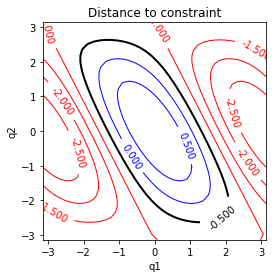

In [ ]:
#@title
#Code for generating the distance to constraint figure
import matplotlib
L1 = 1
L2 = 1
xD = 1
def distance(q1,q2):
    c1 = np.cos(q1)
    c12 = np.cos(q1+q2)
    return L1*c1 + L2*c12 - xD
plt.figure(figsize=(4,4))
X,Y = np.meshgrid(np.linspace(-math.pi,math.pi,40),np.linspace(-math.pi,math.pi,40))
plt.title('Distance to constraint')
CS = plt.contour(X,Y,distance(X,Y),linewidths=[1,1,1,1,1,2,1,1,1],colors=('r','r','r','r','r','k','b','b','b'))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('q1')
plt.ylabel('q2')
plt.show()

To characterize this set, we could choose $q_1$ as the independent DOF
and then solve for $q_2$ analytically. Doing so, we find:
$$q_2 = \pm \cos^{-1}((x_D - c_1 L_1) / L_2) - q_1.$$ The top of the
manifold is given by the positive cosine term, while the bottom is the
negative cosine term. Since the domain of $\cos^{-1}$ is $[-1,1]$,
solutions only exist for the range of $q_1$ such that
$|x_D - c_1 L_1| \leq  L_2$, or in other words,
$(x_D - L_2)/L_1 \leq c_1 \leq (x_D + L_2) /L_1$.


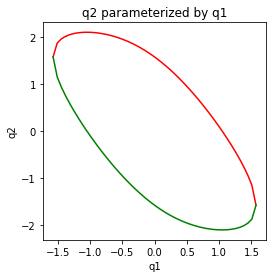

In [ ]:
#@title
#Code for generating the solution figure as a function of q1
c1min = (xD - L2)/L1
c1max = (xD + L2)/L1
def q2_up(q1):
    c1 = np.cos(q1)
    return np.arccos((xD-c1*L1)/L2)-q1
def q2_down(q1):
    c1 = np.cos(q1)
    return -np.arccos((xD-c1*L1)/L2)-q1
plt.figure(figsize=(4,4))
x = np.linspace(-np.arccos(c1min),np.arccos(c1min),50)
plt.title('q2 parameterized by q1')
plt.plot(x,q2_up(x),color='r')
plt.plot(x,q2_down(x),color='g')
plt.xlabel('q1')
plt.ylabel('q2')
plt.show()

We note that the independent DOF could have also been chosen to be
$q_2$. In this case, we must find a solution $q_1$ to:
$$s_1 (- s_2 L_2) + c_1 (L_1 + c_2 L_2) - x_D = 0$$ assuming the
parenthesized terms are fixed. This type of equation
$$a \sin \theta + b \cos \theta + c = 0$$ has the general solution:
$$\theta = \pm \cos^{-1} \frac{c}{\sqrt{a^2+b^2}} + atan2(a,b).$$ Hence,
replacing this in the above equation, we get the solution for $q_1$:
$$q_1 = \pm \cos^{-1}\frac{-x_D}{\sqrt{L_1^2 + L_2^2 + 2 c_2 L_1 L_2}} + atan2(- s_2 L_2, L_1 + c_2 L_2).$$
The inverse cosine only has a solution when
$x_D^2 \leq L_1^2 + L_2^2 + 2 c_2 L_1 L_2$, or in other words,
$c_2 \geq (x_D^2 - L_1^2 - L_2^2)/(2 L_1 L_2)$.

In more complex cases, particularly with $n-m \geq 2$, the domain of
valid independent DOFs becomes more geometrically complex and difficult
to characterize.

### Parallel robots

To define the configuration space of parallel mechanisms, it is useful
to first define an open, possibly branched chain by first imagining
certain loop closure constraints as being broken, and then treating the
broken constraints as IK tasks. Then, $n-m$ of the open DOFs may be
represented as independent DOFs while the remaining $m$ are treated as
dependent DOFs.

Some of the joints of the mechanism will be independently *actuated*. It
is convenient to choose a convention of independent vs dependent DOFs
matching the actuated joints, which are also known as *active* joints,
vs non-actuated joints, which are also known as *passive* joints. It is
also prudent to design joint stops so that singularities of the passive
chain are never reached, because otherwise the mechanism may "lock up"
or exhibit non-deterministic behavior as singularities are reached.

The Jacobian matrix
-------------------

The Jacobian matrix is a fundamental concept in robotics that relates
joint velocities to task space velocities. It also has uses in
estimating the effects of joint positioning errors in terms of workspace
accuracy, as well as in numerical IK methods.

### Partial derivative review

The Jacobian uses the concept of partial derivatives, which is a
generalization of the standard derivative to functions with multiple
arguments. This section gives a short introduction to partial
derivatives.

Given a two-argument function $f(x,y)$, the partial derivative with
respect to $x$, evaluated at $(x,y)$ is denoted
$\frac{\partial f}{\partial x}(x,y)$. It is defined like the normal
derivative, but keeping $y$ constant:
$$\frac{\partial f}{\partial x}(x,y) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x,y) - f(x,y)}{\Delta x}.$$

This can also be thought of as defining an auxiliary function, keeping
$y$ constant, and taking the derivative of that:
$$\frac{\partial f}{\partial x}(x,y) = \frac{d}{dx} g_y(x)$$ where
$g_y(x)$ is defined as: $$g_y(x) \equiv f(x,y)$$

Similarly we can take the partial derivative with respect to $y$:
$$\frac{\partial f}{\partial y}(x,y) = \lim_{\Delta y \rightarrow 0} \frac{f(x,y+\Delta y) - f(x,y)}{\Delta y} = \frac{d}{dy}h_x(y)$$
where $h_x(y) \equiv f(x,y)$.

In general, the partial derivative of a multi-argument function with
respect to some argument is calculated by *treating the remaining
arguments as constant* and simply calculating the regular derivative.
The differential $\frac{\partial f}{\partial x}$ is the function
obtained by partial differentiation of $f$ treating all other arguments
as constants.

Most of the standard derivative rules apply to partial derivatives:

-   Additive:
    $\frac{\partial (f+g)}{\partial x}(x,y) = \frac{\partial f}{\partial x}(x,y) + \frac{\partial g}{\partial x}(x,y)$

-   Scalar multiplication:
    $\frac{\partial (cf)}{\partial x}(x,y) = c \frac{\partial f}{\partial x}(x,y)$

-   Multiplicative:
    $\frac{\partial (f(x,y)g(x,y))}{\partial x} = \frac{\partial f(x,y)}{\partial x} g(x,y) + \frac{\partial g(x,y)}{\partial x}f(x,y)$

There are also generalizations of the chain rule:

-   If $h(x,y) = f(g(x,y))$, then
    $\frac{\partial h(x,y)}{\partial x} = f^\prime(g(x,y)) \frac{\partial g(x,y)}{\partial x}$

-   If $h(x,y) = f(g(x),y)$, then
    $\frac{\partial h(x,y)}{\partial x} = \frac{\partial f(g(x),y)}{d g} g^\prime(x)$

Also if a function is not dependent on some variable, then its partial
derivative with respect to that variable is nil:
$$\frac{\partial f(y)}{\partial x} = 0$$

### Jacobian definition

The Jacobian of an arbitrary vector function $\mathbf{x} = f(\mathbf{q})$, with
$f: \mathbb{R}^n \rightarrow \mathbb{R}^m$ is given as the following
matrix of *partial derivatives*:

$$J(\mathbf{q}) \equiv \frac{\partial f(\mathbf{q})}{\partial \mathbf{x}} \equiv \begin{bmatrix}
\frac{\partial f_1(\mathbf{q})}{\partial q_1} & \cdots & \frac{\partial f_1(\mathbf{q})}{\partial q_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_m(\mathbf{q})}{\partial q_1} & \cdots & \frac{\partial f_m(\mathbf{q})}{\partial q_n} 
\end{bmatrix}$$

where $f$'s component functions are given by the individual $f_i$'s:

$$f(\mathbf{q}) \equiv \begin{bmatrix} f_1(\mathbf{q}) \\ \vdots \\ f_m(\mathbf{q}) \end{bmatrix}.$$

Observe that each of the rows of the Jacobian correspond to each of the
component functions, and each column corresponds to derivatives of a
single joint coordinate. It is also important to note that the Jacobian
is dependent on the configuration.


#### Single joint example

As an example, let us consider a single joint planar robot with its
joint at the origin, and an end effector at $L_1$ distance away from the
origin. The world coordinates of the end effector are:
$$\mathbf{x}(\mathbf{q}) = \begin{bmatrix}{L_1 \cos q_1} \\ {L_1 \sin q_1} \end{bmatrix}.$$ 

The Jacobian
of this point is a $2\times 1$ matrix obtained by taking the derivative
with respect to each of the joint coordinates, which is just $q_1$ in
this case.
$$J(\mathbf{q}) \equiv \frac{\partial \mathbf{x}}{\partial \mathbf{q}}(\mathbf{q}) = \begin{bmatrix}{\partial (L_1 \cos q_1) / \partial q_1} \\ {\partial (L_1 \sin q_1) / \partial q_1} \end{bmatrix} = \begin{bmatrix}{-L_1 \sin q_1} \\ {L_1 \cos q_1} \end{bmatrix}.$$


Note that this is perpendicular to the direction from the joint to the
end effector, with the same magnitude.

The significance of the Jacobian in this case is that *it gives the
instantaneous velocity of the point* $\mathbf{x}$, in world coordinates, as
$q_1$ rotates at 1 rad/s. If $q_1$ rotates at another velocity
$\dot{q}_1$ (the dot denotes time derivative), then the end effector
velocity is given by: $$\dot{\mathbf{x}} = J(\mathbf{q}) \dot{q}_1.$$ This holds
as a consequence of the chain rule. Note that this equation only holds
in the 1 joint case; let us now discuss a more general case.

#### Two joint example

Now consider the two joint planar arm [described above](#2R-manipulator). The end effector has world position
$$\mathbf{x}(\mathbf{q}) = \begin{bmatrix}{c_1(L_1 + c_2 L_2) - s_1 s_2 L_2} \\ {s_1(L_1 + c_2 L_2) + c_1 s_2 L_2} \end{bmatrix}.$$
The first column of the Jacobian is the partial derivative with respect
to $q_1$, keeping $q_2$ constant:
$$\frac{\partial \mathbf{x}}{\partial q_1}(\mathbf{q}) = \begin{bmatrix}{-s_1(L_1 + c_2 L_2) - c_1 s_2 L_2} \\ {c_1(L_1 + c_2 L_2) - s_1 s_2 L_2} \end{bmatrix}.$$
The second column is the partial derivative with respect to $q_2$,
keeping $q_1$ constant:
$$\frac{\partial \mathbf{x}}{\partial q_2}(\mathbf{q}) = \begin{bmatrix}{-c_1 s_2 L_2 - s_1 c_2 L_2} \\ {- s_1 s_2 L_2 + c_1 c_2 L_2} \end{bmatrix}.$$
Overall, the Jacobian matrix is a $2\times 2$ matrix as follows:
$$J(\mathbf{q}) = \begin{bmatrix}{-s_1(L_1 + c_2 L_2) - c_1 s_2 L_2} & {- c_1 s_2 L_2 - s_1 c_2 L_2} \\ {c_1(L_1 + c_2 L_2) - s_1 s_2 L_2} & {-s_1 s_2 L_2 + c_1 c_2 L_2} \end{bmatrix}.$$
Observe that the first column is simply a vector perpendicular to
$\mathbf{x}$ with the same magnitude. The second column is a bit more
challenging to interpret, but with a bit of scrutiny it can be seen as a
vector perpendicular and with the same magnitude as the displacement
vector from the second joint position to $\mathbf{x}$.

This means that if $q_1$ were to rotate at velocity $\dot{q}_1$ while
$q_2$ is held constant, then the end effector would have instantaneous
velocity: $$\dot{q}_1 \frac{\partial \mathbf{x}}{\partial q_1}(\mathbf{q}).$$
Likewise, if $q_2$ were to rotate at velocity $\dot{q}_2$, and $q_1$
were to be held constant, then the velocity would be:
$$\dot{q}_2 \frac{\partial \mathbf{x}}{\partial q_2}(\mathbf{q}).$$ If both were
to rotate simultaneously, then the velocity would be
$$\dot{\mathbf{x}}(\mathbf{q}) = \dot{q}_1 \frac{\partial \mathbf{x}}{\partial q_1}(\mathbf{q}) + \dot{q}_2 \frac{\partial \mathbf{x}}{\partial q_2}(\mathbf{q}) = J(\mathbf{q})\dot{\mathbf{q}}.$$
[Fig. 6](#fig:Jacobian2R) illustrates this concept. 


************

![fig:Jacobian2R](https://github.com/krishauser/RoboticSystemsBook/blob/master/figures/modeling/jacobian_2R.png?raw=1)

<div class="figcaption"><a name="fig:Jacobian2R">Figure 5</a>.
The Jacobian relates joint space velocities to Cartesian velocities.
The first column of the Jacobian gives the velocity at which the end
effector would move if the first joint moves at unit speed, and the
second column gives its velocity if the second joint moves at unit
velocity. The linear combination of Jacobian columns, weighted by joint
speed, gives the overall Cartesian velocity.</div>

************


### Formula for arbitrary branched robots

In general, using the forward kinematics formula given in Chapter 4:
$$T_i(\mathbf{q}) = T_{p[i]}(\mathbf{q}) T_{i\rightarrow p[i]}^{ref} L_{z_i,\mathbf{a}_i}(q_i)$$
we can derive the Jacobian of an end effector point on any link $n$. Let
$A(n)$ denote the set of *ancestors* of link $n$, that is, $n$, its
parent, its parent's parent, and so on down to the root. Let the task
space $\mathbf{x} = f(\mathbf{q})$ be given by the position of an end effector on
the $n$'th link, and $\mathbf{x}_n$ are its local coordinates.

If $j \notin A(n)$, then joint $j$ does not affect the end effector. In
this case, the $j$'th column of the Jacobian is zero.

Otherwise, the $j$'th column of the Jacobian is given by:
$$\frac{\partial f}{\partial q_j}(\mathbf{q}) = T_{p[j]}(\mathbf{q}) T_{j\rightarrow p[j]}^{ref} \frac{d L_{z_j,\mathbf{a}_j}}{d q_j}(q_j) T_{n\rightarrow j}(\mathbf{q}) \mathbf{x}_n$$
Where $T_{n\rightarrow j}(\mathbf{q}) = T_j^{-1}(\mathbf{q}) T_n(\mathbf{q})$ is the
transform from local coordinates on link $n$ to local coordinates on
link $j$, at configuration $\mathbf{q}$. Note that
$T_{n\rightarrow j}(\mathbf{q})$ only depends on the joint angles of $j$'s
descendants, not including $j$.

#### Planar robots

For 2D revolute joints, we have no joint type nor axis, so the local
transform is given as: $$L_{z,\mathbf{a}}(q) \equiv R(q) = 
\left[\begin{array}{ccc}
\cos q & -\sin q & 0 \\
\sin q & \cos q & 0 \\
0 & 0 & 1
\end{array}\right]$$ in homogeneous coordinates, and hence the matrix
derivative is given by $$\frac{d}{dq} R(q) = 
\left[\begin{array}{ccc}
-\sin q & -\cos q & 0 \\
\cos q & -\sin q & 0 \\
0 & 0 & 0
\end{array}\right].$$ (Note that the bottom left entry dropped from 1 to
0, indicating that the derivative of a position quantity is a
directional quantity).

A more compact expression of this derivative is as follows:
$$\frac{d}{dq} R(q) = R(q)
\left[\begin{array}{ccc}
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 
\end{array}\right]$$ and hence we obtain the compact expression for the
Jacobian $$\frac{\partial f}{\partial q_j}(\mathbf{q}) = T_j(\mathbf{q})
\left[\begin{array}{ccc}
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 
\end{array}\right]
T_{n\rightarrow j}(\mathbf{q}) \mathbf{x}_n.$$ This shows that the Jacobian column
corresponding to a revolute joint is perpendicular to the vector from
the joint to the end effector (rotated $90^\circ$ CCW).
[Fig. 6](#fig:Jacobian3R) illustrates this principle.


*************

![fig:Jacobian3R](https://github.com/krishauser/RoboticSystemsBook/blob/master/figures/modeling/jacobian_3R.png?raw=1)

<div class="figcaption"><a name="fig:Jacobian3R">Figure 6</a>.
The Jacobian of a planar 3R robot. Its columns are determined by
taking the perpendicular vector to the displacement vector from the
joint center to the end effector. The Jacobian is different for
different configurations (a) and (b).
</div>

*************

For a prismatic joint, we have a local transform: $$L_{z,\mathbf{a}}(q) = 
\left[\begin{array}{ccc}
1 & 0 & a_x q \\
0 & 1 & a_y q \\
0 & 0 & 1
\end{array}\right]$$ and hence the derivative is
$$\frac{d}{dq} L_{z,\mathbf{a}}(q) = 
\left[\begin{array}{ccc}
0 & 0 & a_x \\
0 & 0 & a_y \\
0 & 0 & 0
\end{array}\right].$$

Since this matrix wipes out the $x$ and $y$ coordinates of whatever
homogeneous point it multiplies and replaces it with $(a_x,a_y,0)$, we
can express the Jacobian column with the simplified expression
$$\frac{\partial f}{\partial q_j}(\mathbf{q}) = T_j(\mathbf{q}) \begin{bmatrix}a_{j,x} \\ a_{j,y} \\ 0\end{bmatrix}.$$ 

Note that since the homogeneous coordinate is 0, the translation of the
transform $T_j$ does not affect the result, and hence the Jacobian
column is simply the world direction of the joint axis $\mathbf{a}_j$.

### 3D robots

For 3D revolute joints, the local transform is given by an axis-angle
rotation: $$L_{z,\mathbf{a}}(q) \equiv R_{aa}(\mathbf{a},q)$$ The velocity of a
point $X$ being rotated along with the rotation frame at unit velocity
$\dot{q}$ is given by its cross product with the rotation axis:
$$\frac{d}{dt} \mathbf{x} = \mathbf{a} \times \mathbf{x}.$$ Here $\mathbf{x}$ is the
post-rotation coordinates of the point. Since multiplication with a
rotation matrix $R_{aa}(\mathbf{a},q)$ converts pre-rotation coordinates to
post-rotation coordinates, the angular velocity of a point given with
pre-rotation coordinates $\mathbf{x}_L$ is given by
$$\frac{d}{dt} \mathbf{x} = \mathbf{a} \times R_{aa}(\mathbf{a},q) \mathbf{x}_L.$$ Since the
cross product axis and the rotation axis are the same, Rodrigues'
formula can be used to switch the order of the cross product:
$$\mathbf{a} \times (R_{aa}(\mathbf{a},q) \mathbf{x}_L) =  R_{aa}(\mathbf{a},q) (\mathbf{a} \times \mathbf{x}_L).$$
Finally, using the skew-symmetric product notation $\hat{\cdot}$ used in
Chapter 2 we obtain
$$\frac{d}{dt} R_{aa}(\mathbf{a},q) \mathbf{x}_L = R_{aa}(\mathbf{a},q) \hat{\mathbf{a}} \mathbf{x}_L$$
and since this holds for all $\mathbf{x}_L$, we see that
$$\frac{d}{dt} R_{aa}(\mathbf{a},q) = R_{aa}(\mathbf{a},q) \hat{\mathbf{a}}.$$
Replacing this in the Jacobian expression and converting to homogeneous
coordinates, we obtain the simplified expression:

$$\frac{\partial f}{\partial q_j}(\mathbf{q}) = T_j(\mathbf{q})
\left[\begin{array}{c|c}
\hat{\mathbf{a}} & 0  \\
\hline
0 & 0  
\end{array}\right]
T_{n\rightarrow j}(\mathbf{q}) \mathbf{x}_n.

\label{eq:JacobianRevolute3D}
$$

Another way to interpret this is that
the $j$'th column of the Jacobian is the cross-product between the axis
of joint $j$ and the vector pointing from joint $j$ to the end effector
(both given in world coordinates). To see this, note that the axis in
world coordinates is $R_j\mathbf{a} = T_j \begin{bmatrix} \mathbf{a} \\ 0 \end{bmatrix}$ and the
displacement vector is $T_n \mathbf{x}_n - \mathbf{t}_j$. Here, $R_j$ is the
orientation of link $j$, $\mathbf{t}_j$ is its origin, we have implicitly
assumed dependence on $\mathbf{q}$, and we slightly abuse notation to convert
freely between homogeneous and standard coordinates. The displacement
vector could also be expressed as
$R_j T_{n\rightarrow j} \mathbf{x}_n + \mathbf{t}_j - \mathbf{t}_j = R_j T_{n\rightarrow j} \mathbf{x}_n$.

Hence, by the distributive property of the cross-product,
$$R_j\mathbf{a} \times R_j T_{n\rightarrow j} \mathbf{x}_n = R_j (\mathbf{a} \times T_{n\rightarrow j} \mathbf{x}_n) = R_j \hat{\mathbf{a}} T_{n \rightarrow j} \mathbf{x}_n$$
which is equivalent to ($\ref{eq:JacobianRevolute3D}$).

For prismatic joints, a derivation similar to the planar case gives the
simplified expression:
$$\frac{\partial f}{\partial q_j}(\mathbf{q}) = T_j(\mathbf{q}) \begin{bmatrix}\mathbf{a}_j \\ \hline 0 \end{bmatrix}.$$
Similar derivations exist for helical and other exotic joint types.

#### Orientation jacobians

For task spaces that include orientation components, the Jacobian of the
orientation components can also be computed in a straightforward manner.
The orientation Jacobian $J_\theta$ converts joint velocities into the
angular velocity of the link containing the end effector. In 2D, angular
velocity is simply a scalar and hence $J_\theta$ is a $1\times n$
matrix. In 3D, angular velocity is a 3D vector, and hence $J_\theta$ is
a $3 \times n$ matrix.

First, any prismatic joints do not affect orientation, and hence the
columns of the orientation Jacobian corresponding to such joints are
zero.

For revolute joints in 2D, each joint affects the orientation of the end
effector equally. Hence, each column of $J_\theta$ corresponding to a
revolute joint is 1.

In 3D, an angular velocity vector is a vector $\boldsymbol{\omega}$ such that for
any point $\mathbf{x}$ expressed in world coordinates but attached to link
$n$, its instantaneous velocity will be:
$$\boldsymbol{\omega}\times (\mathbf{x} - \mathbf{t}_n) + \dot{\mathbf{t}}_n$$ where $\mathbf{t}_n$
is the origin of link $n$. Hence, the angular velocity at the end
effector is simply the angular velocity of link $n$. The angular
velocity of each revolute joint are summed to obtain the angular
velocity of the end effector:
$$\boldsymbol{\omega} = \sum_{j\text{ is revolute}} J_{\theta,j}(\mathbf{q})\dot{q}_j$$
Hence the $j$'th column of the Jacobian is:
$$J_{\theta,j}(\mathbf{q}) = T_j(\mathbf{q}) \begin{bmatrix}\mathbf{a}_j \\ \hline 0 \end{bmatrix}$$ where
the multiplication orients the local axis to the world coordinate frame.

It is important to note that $\boldsymbol{\omega}$ is usually not the derivative
of a given rotation representation, like Euler angles. Instead, it is
that an additional transformation is typically necessary to obtain the
derivative of the orientation representation used in the task coordinate
$\mathbf{x}$.

### Significance and interpretation

#### Relating joint and task velocities

The general formula relating joint space velocities to task space
velocities is: $$\dot{\mathbf{x}} = J(\mathbf{q}) \dot{\mathbf{q}}$$ where $J$ is the
Jacobian of the task space map. In other words, the $i$'th column of $J$
gives the velocity at which the end effector would move if the $i$'th
joint were to move at unit velocity.

#### As a Taylor expansion

Another interpretation of the Jacobian is as an $n$-dimensional analogue
of Taylor expansion. Recall that the 1st order Taylor expansion of a
normal 1-D, differentiable function is the linear approximation:
$$f(x + \Delta x) = f(x) + f^\prime(x)\cdot \Delta x + O(\Delta x^2)$$
where $O(h^2)$ denotes a term smaller than a constant times $h^2$ as $h$
decreases asymptotically to 0. This means that a function is
increasingly better approximated with the line
$y = f(x) + \Delta x f^\prime(x)$ as $\Delta x$ shrinks toward 0.

The Jacobian appears in the $n$-dimensional Taylor expansion of a
multidimensional differentiable function:
$$f(\mathbf{x} + \Delta \mathbf{x}) = f(\mathbf{x}) + J(\mathbf{x}) \Delta \mathbf{x} + O(\|\Delta \mathbf{x}\|^2).$$
This states that an arbitrary function is well-approximated as a
hyperplane $$\mathbf{y} = f(\mathbf{x}) + J(\mathbf{x}) \Delta \mathbf{x}$$ as
$\Delta \mathbf{x}$ shrinks toward 0.


#### Use in error propagation

Another important use of the Jacobian is in error propagation. Suppose
that at a robot has configuration $\mathbf{q}$ but with a joint space error
$\boldsymbol{\epsilon}$. Then the task-space error
$$f(\mathbf{q}+\boldsymbol{\epsilon}) - f(\mathbf{q})$$ is approximated by the Taylor
expansion
$$f(\mathbf{q}+\boldsymbol{\epsilon}) - f(\mathbf{q}) \approx J(\mathbf{q}) \boldsymbol{\epsilon}$$ if
$\epsilon$ is small. In terms of absolute magnitude, the task space
error is $\| J(\mathbf{q}) \boldsymbol{\epsilon}\|$. We can also bound the error:
$$\| J(\mathbf{q}) \boldsymbol{\epsilon}\| \leq \sum_{i=1}^n |\epsilon_{i}| \|J_i(\mathbf{q})\|$$
where $J_i$ is the $i$'th column of the Jacobian. As a result if joint
$i$ had an error, the norm of $J_i$ approximates the corresponding error
in task space.

In general, in $n$R planar robots, the $i$'th column of the Jacobian is
simply the vector from the $i$'th joint to the end effector, rotated by
$90^\circ$ CCW. This has the significance that if the end effector is
farther from revolute joint $i$ than joint $j$, then the magnitude of
the $i$'th column is greater than the magnitude of the $j$'th column.
Usually, this means that errors and movements of joints close to the
robot's base have a larger effect than joints closer to the end
effector.


### Manipulability and singularity identification

TODO


### Null-space motion computation

TODO 


Numerical IK
------------

Numerical IK methods are highly general techniques that can accommodate
arbitrary robot mechanisms and task spaces, without any need for
mechanism-specific mathematics besides forward kinematics and Jacobian
computations. As a result they are preferable for use in software
packages that are compatible with multiple robot types. However, they
have a few drawbacks: they involve much more computation than analytical
approaches, only provide point solutions, and may fall prey to local
minima. Robotics practitioners must be aware of these drawbacks when
building systems based on numerical IK techniques.

All numerical approaches share a common iterative structure. First, let
$f(\mathbf{q})$ denote the task space error (rather than task coordinate).
These methods are given a seed configuration $\mathbf{q}_0$, and iteratively
improve it to obtain a sequence $\mathbf{q}_1,\mathbf{q}_2,\ldots,\mathbf{q}_k$ with
decreasing error values $\|f(\mathbf{q}_i)\|$. The iteration can terminate
when the error decreases below some threshold, or when $i$ exceeds an
iteration limit $k$. However, they differ in their approach for
calculating these iterates.

### Cyclic Coordinate Descent

Cyclic Coordinate Descent (CCD) is an appealing numerical method that
only uses geometric reasoning to derive subsequent iterates. The idea is
to move each joint independently so that it minimizes error between the
end effector and the target (coordinate descent), and iterate through
all the joints repeatedly (making it cyclic).

*********************

<a name="alg:CCD">**Algorithm CCD**</a>
1. **for** $i=1,\ldots,k$ **do**
2. &nbsp;&nbsp;&nbsp;$\mathbf{q}_i \gets \mathbf{q}_{i-1}$
3. &nbsp;&nbsp;&nbsp;**for** all joints $j = 1,...,n$ $do$
4. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Compute $q_j^* = \arg \min_{q_j} \|f(\mathbf{q}_i)\|$
5. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Set $\mathbf{q}_{i,j} \gets q_j^*$
6. **return** $\mathbf{q}_k$

*********************

CCD iterates by performing $k$ passes through the joints as listed in
[Algorithm CCD](#alg:CCD). On each pass, it loops through the $n$ joints, and
modifies each joint $j$ assuming the rest of the robot is fixed.
Specifically, line 4 finds the value that minimizes the error keeping
the rest of $\mathbf{q}_i$ constant, and this is updated in $\mathbf{q}_i$ in line 5.
This procedure iterates until $N$ passes have been made, or
convergence has been reached. Note that the error $\|f(\mathbf{q}_i)\|$ will
never increase. However, it may terminate without convergence in the
case that a singularity is reached.

To make CCD converge quickly, the single-joint minimization in Line 4
should be fast. In many cases there are closed-form solutions to this
problem. For 2D robots with positioning tasks, this consists of finding
the angle $\theta_j$ between the $j$'th joint and the end effector and
the angle $\theta_j^\prime$ between the $j$'th joint and the target.
Then $q_j$ is displaced from its current value by
$\theta_j^\prime - \theta_j$.

The figure below shows the result of CCD for a 2R manipulator reaching the point (1,0.5).  The first plot shows the sequence of configurations starting from $q_0=(0,0)$, the second shows the end effector point for the sequence, and the third shows the error at each iteration.


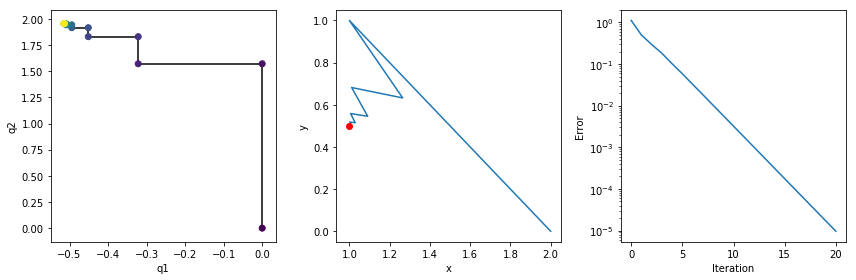

In [ ]:
#@title
#Code for generating the CCD figure
xD = np.array([1.,0.5])
q0 = np.array([0.,0.])
L = [1,1]
def fk_all(q):
    theta = 0
    res = []
    joint = np.array([0.,0.])
    for i in range(len(L)):
        theta += q[i]
        ci = np.cos(theta)
        si = np.sin(theta)
        joint = joint + np.array([ci*L[i],si*L[i]])
        res.append(joint)
    return res
def error(q):
    return np.linalg.norm(fk_all(q)[-1] - xD)
def CCD_i(q,i):
    xs = fk_all(q)
    ee = xs[-1]
    #joint positions
    js = [np.array([0,0])] + xs[:-1]
    jointi = js[i]
    theta_target = np.arctan2(xD[1]-jointi[1],xD[0]-jointi[0])
    theta_ee = np.arctan2(ee[1]-jointi[1],ee[0]-jointi[0])
    dtheta = theta_target - theta_ee
    qnext = np.copy(q)
    qnext[i] += dtheta
    return qnext
iterates = [q0]
for i in range(10):
    iterates.append(CCD_i(iterates[-1],1))
    iterates.append(CCD_i(iterates[-1],0))
e = [error(q) for q in iterates]
xy = [fk_all(q)[-1] for q in iterates]
iterates = np.vstack(iterates)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax1.plot(iterates[:,0],iterates[:,1],color='k',zorder=1)
ax1.scatter(iterates[:,0],iterates[:,1],c=range(len(iterates)),zorder=2)
ax1.set_xlabel('q1')
ax1.set_ylabel('q2')
ax2 = fig.add_subplot(132)
ax2.plot([v[0] for v in xy],[v[1] for v in xy],zorder=1)
ax2.scatter([xD[0]],[xD[1]],color='r',zorder=2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax3 = fig.add_subplot(133)
ax3.semilogy(range(len(e)),e)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Error")
fig.tight_layout()
plt.show()

In 3D, the situation is similar, except the
angles are calculated on the plane orthogonal to the joint axis. When
combined position and orientation tasks are considered, the derivation
of the optimal solution is more difficult because the solution must
trade off between the two competing objectives. We refer the interested
reader to external readings for more details.

CCD in general is not as sensitive to the initial seed as other methods,
and reduces error quickly in the first few iterations. However, it may
be slow in converging to tight tolerances. The reason is that certain
end effector motions can only be attained by a coordinated, simultaneous
motion of two or more joints, and individual moves along either
coordinate axis increases error (the error function contains a diagonal
"valley").  An example of this is shown in the below figure, where a 4R serial manipulator with unit lengths
is used to get toward the point (4,0).  The start configuration is $q=(\pi/2,\pi/2,\pi/2,\pi/2)$, and the solution
is straightened out, $q=(0,0,0,0)$.  Even after 40 iterations, the method still has a relatively large error.

Due to this behavior, CCD is often used as a precomputation step to
get reasonably close to the target, and then some other numerical
procedure is used for the final steps.


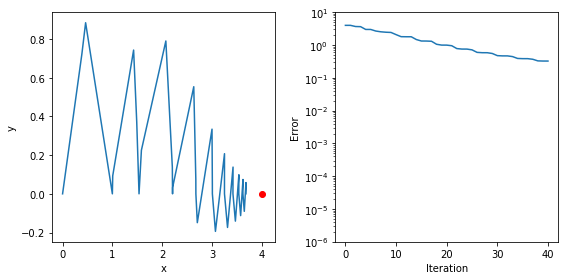

In [ ]:
#@title
#Code for generating the 4R CCD figure
q0 = np.array([math.pi/2,math.pi/2,math.pi/2,math.pi/2])
xD = np.array([4,0])
L = [1,1,1,1]
iterates = [q0]
for i in range(10):
    for k in range(3,-1,-1):
        iterates.append(CCD_i(iterates[-1],k))
e = [error(q) for q in iterates]
xy = [fk_all(q)[-1] for q in iterates]
iterates = np.vstack(iterates)
fig = plt.figure(figsize=(8,4))
ax2 = fig.add_subplot(121)
ax2.plot([v[0] for v in xy],[v[1] for v in xy],zorder=1)
ax2.scatter([xD[0]],[xD[1]],color='r',zorder=2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax3 = fig.add_subplot(122)
ax3.semilogy(range(len(e)),e)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Error")
ax3.set_ylim(1e-6,10)
fig.tight_layout()
plt.show()

### Root-finding methods

The class of root-finding methods attempt to solve for a zero of the
error function $f(\mathbf{q})=0$ using iterative solutions of the 1st Taylor
expansion. In particular, we will discuss the Newton-Raphson method, a
multi-dimensional analogue of Newton's method in 1D.

#### Derivation from Taylor expansion

For a 1D function $f(x)$, Newton's method repeatedly approximates the
curve at an iterate $x_i$ as a line through $(x_i,f(x_i))$ using Taylor
expansion, and solves for the intersection of the line and the $x$ axis.
The iteration in Newton's method sets
$$x_{i+1} = x_i - f(x_i) / f^\prime(x_i).$$ If the line is locally a
good fit to $f$, then the next iteration gets very close to the root. In
this case we say that the method *converges*. In fact, it can be proven
to obtain a quadratic order of convergence for most "well-behaved"
functions.

In the multidimensional case, we seek the next iterate
$\mathbf{q}_{i+1} = \mathbf{q}_i + \Delta \mathbf{q}_i$ to solve the following Taylor
expansion: $$\label{eq:NewtonRaphson}
0 = f(\mathbf{q}_i) + J(\mathbf{q}_i) \Delta \mathbf{q}_i.$$ In the nonredundant case
where $n = m$, the Jacobian is square and this system of linear
equations can be solved via matrix inversion as long as $J(\mathbf{q}_i)$ is
invertible. The matrix is invertible as long as the robot is not at a
singularity.

However, in the redundant $n > m$ case, the Jacobian is not even square.
Here there is a linear subspace of values of $\Delta \mathbf{q}_i$ that
satisfy this equation. Luckily there is generalization of the matrix
inverse known as the *pseudoinverse* that allows for solving for a
unique value of $\Delta \mathbf{q}_i$ that not only
solves ($\ref{eq:NewtonRaphson}$) but also minimizes the amount of deviation
from the previous iterate. See
[Appendix A.1](LinearAlgebra.ipynb#Matrix-pseudoinverse) for more information. The pseudoinverse
solution $\Delta \mathbf{q}_i = -J(\mathbf{q}_i)^+ f(\mathbf{q}_i)$ is the solution
that minimizes the joint space deviation $\| \Delta \mathbf{q}_i \|$.

The below figures show how quickly Newton-Raphson finds a very accurate solution for the 4R manipulator that CCD had trouble with above.  Within 8 iterations the error is less than 1/1000 units, and in 15 iterations the error is approximately 10<sup>-7</sup> units.

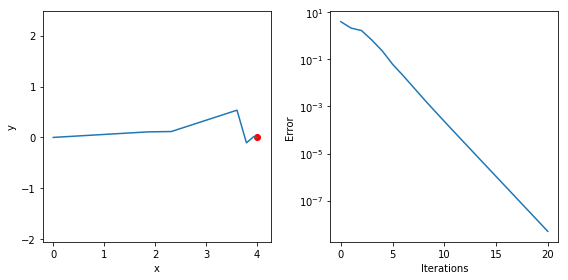

In [ ]:
#@title
#Code for the Newton-Raphson example 

q0 = np.array([math.pi/2,math.pi/2,math.pi/2,math.pi/2])

def fk_jac(q):
    xs = fk_all(q)
    js = [np.array([0.,0.])] + xs[:-1]
    cols = []
    for i in range(len(L)):
        d = xD - js[i]
        cols.append([-d[1],d[0]])
    return np.array(cols).T

def basic_newton(q0,N):
    #uses standard pseudoinverse to determine newton step
    trace = [q0]
    for i in range(N):
        q = trace[-1]
        J = np.linalg.pinv(fk_jac(q))
        f = fk_all(q)[-1] - xD
        dq = -np.dot(J,f)
        qnext = q+dq
        trace.append(qnext)
    return trace

trace = basic_newton(q0,20)
xy = [fk_all(q)[-1] for q in trace]
err = [error(q) for q in trace]
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.plot([v[0] for v in xy],[v[1] for v in xy])
ax1.scatter([xD[0]],[xD[1]],color='r',zorder=2)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.axis('equal')
ax2 = fig.add_subplot(122)
ax2.semilogy(range(len(err)),err)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Error')
fig.tight_layout()
plt.show()

There is also a variant of the pseudoinverse called the *weighted
pseudoinverse* in which the solution does not minimize $\| x \|$ but
rather minimizes a weighted norm $x^T W x$ where $W$ is a symmetric
weight matrix. In the context of IK, $W$ is usually a diagonal matrix
that weights the relative movement of each joint, with higher weights
penalizing larger movements. 

#### Step direction and size, divergence

In total, the Newton-Raphson method chooses the step direction as
follows: $$\label{eq:NewtonRaphsonStep}
\Delta \mathbf{q}_i = - J^+(\mathbf{q}_i) f(\mathbf{q}_i)$$

Unfortunately, Newton's method does not always converge if the initial
guess is too far from a root. The sequence of iterates may oscillate or
even diverge toward infinity. The step size may also become huge as the
robot approaches a singularity, where taking the inverse effectively approaches
dividing by zero. 

In the following example, the 4R robot is asked to reach the point (2,0.001) from the outstretched configuration $q=(0,0,0,0)$.  Since the robot starts at a singularity, the initial step size is huge!  It moves over 1,000 rad, which almost certainly would not be a preferred solution.

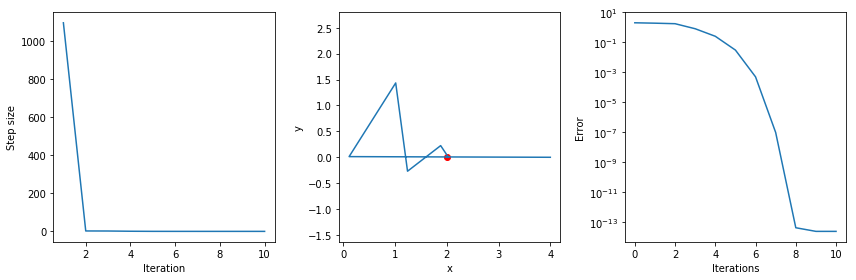

In [ ]:
#@title
#Code for the large step size Newton-Raphson example

xD = np.array([2.0,0.001])
q0 = np.array([0,0,0,0])

trace = basic_newton(q0,10)
xy = [fk_all(q)[-1] for q in trace]
err = [error(q) for q in trace]
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax1.plot(range(1,len(trace)),[np.linalg.norm(trace[i]-trace[i-1]) for i in range(1,len(trace))])
ax1.set_ylabel('Step size')
ax1.set_xlabel('Iteration')
ax2 = fig.add_subplot(132)
ax2.plot([v[0] for v in xy],[v[1] for v in xy])
ax2.scatter([xD[0]],[xD[1]],color='r',zorder=2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.axis('equal')
ax3 = fig.add_subplot(133)
ax3.semilogy(range(len(err)),err)
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Error')
fig.tight_layout()
plt.show()

There are multiple ways of keeping the step size small. One
straightforward method is known as a line search , in which the entire
step $\Delta \mathbf{q}_i$ is not taken, but rather a scaled step
$$\mathbf{q}_{i+1} = \mathbf{q}_i + \alpha_i \Delta \mathbf{q}_i$$ is taken, with
$\alpha_i > 0$ a parameter chosen at each step. The step size is usually
taken to obtain a sufficient decrease in the error function value. One
simple way of doing this is to start with some value of $\alpha_i$, and
if it increases the error function value, then to scale it by some
number $< 1$. This repeats until a suitable step size is found. A
decrease will be eventually found as $\alpha_i$, unless the problem is
at a local minimum, or a numerical error has occurred.

Another method is to penalize steps that are too large in the
pseudoinverse itself, which is known as a *damped pseudoinverse* method
. In this method, the step size is allowed to deviate from solving the
root finding problem by instead minimizing the regularized least squares
function:
$$\min_{\Delta \mathbf{q}} \| f(\mathbf{q}) + J(\mathbf{q})\Delta \mathbf{q} \|^2 + \gamma^2 \| \Delta \mathbf{q} \|^2.$$
The $\gamma$ term affects how much the step length is penalized compared
to the error term. It can be shown that the result is simply
$$J^+_\gamma = V (\Sigma + \gamma I)^{-1} U^T$$ where $U \Sigma V^T$ is
the SVD of $J(\mathbf{q})$.

As the figure below shows, the damped pseudoinverse regulates the step size more strongly as $\gamma$ increases.  However, this comes at a cost of a slower convergence rate.  Adding a line search is extremely helpful, as the initial step size is not too large and the error is guaranteed not to increase on each step.


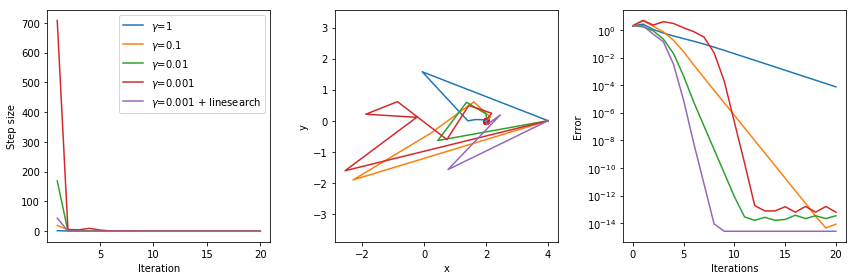

In [ ]:
#@title
#Code for the damped pseudoinverse + line search figures

def damped_pinv(A,gamma):
    u,s,vh = np.linalg.svd(A)
    #only take the first K rows
    vh = vh[:len(s),:]
    s += np.array([gamma]*len(s))
    sinv = np.divide(1.0,s)
    return np.dot(np.dot(vh.T,np.diag(sinv)),u.T)

def damped_newton(q0,N,gamma):
    #uses damped pseudoinverse to determine newton step
    trace = [q0]
    for i in range(N):
        q = trace[-1]
        J = damped_pinv(fk_jac(q),gamma)
        f = fk_all(q)[-1] - xD
        dq = -np.dot(J,f)
        qnext = q+dq
        trace.append(qnext)
    return trace

def damped_newton_linesearch(q0,N,gamma):
    #uses damped pseudoinverse and simple line search with bisection to determine newton step
    trace = [q0]
    for i in range(N):
        q = trace[-1]
        J = damped_pinv(fk_jac(q),gamma)
        f = fk_all(q)[-1] - xD
        dq = -np.dot(J,f)
        alpha = 1.0
        f0 = np.dot(f,f)
        while alpha > 1e-6:
            qnext = q+alpha*dq
            f = fk_all(qnext)[-1] - xD
            fnext = np.dot(f,f)
            if fnext < f0:
                break
            else:
                alpha *= 0.5
        trace.append(qnext)
    return trace

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

N=20
gammas = [1,0.1,0.01,0.001]
for gamma in gammas:
    label = '$\gamma$='+str(gamma)
    trace = damped_newton(q0,N,gamma)
    xy = [fk_all(q)[-1] for q in trace]
    err = [error(q) for q in trace]
    ax1.plot(range(1,len(trace)),[np.linalg.norm(trace[i]-trace[i-1]) for i in range(1,len(trace))],label=label)
    ax2.plot([v[0] for v in xy],[v[1] for v in xy])
    ax2.scatter([xD[0]],[xD[1]],color='r',zorder=2)
    ax3.semilogy(range(len(err)),err)
label = '$\gamma$=0.001 + linesearch'
trace = damped_newton_linesearch(q0,N,0.001)
xy = [fk_all(q)[-1] for q in trace]
err = [error(q) for q in trace]
ax1.plot(range(1,len(trace)),[np.linalg.norm(trace[i]-trace[i-1]) for i in range(1,len(trace))],label=label)
ax2.plot([v[0] for v in xy],[v[1] for v in xy])
ax2.scatter([xD[0]],[xD[1]],color='r',zorder=2)
ax3.semilogy(range(len(err)),err)   

ax1.set_ylabel('Step size')
ax1.set_xlabel('Iteration')
ax1.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.axis('equal')
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Error')

fig.tight_layout()
plt.show()

### Minimization methods

Minimization methods attempt to minimize the error function
$\| f(\mathbf{q}) \|$ (usually expressed as minimizing squared error
$\| f(\mathbf{q}) \|^2$ for ease of computation). They are similar to
root-finding methods, but produce more "reasonable" results when a
solution does not exist, since the result should be as close as possible
to attaining the target task. The simplest method is *gradient descent*
but higher-order methods are also available as described in
[Appendix B.2](Optimization.ipynb#Gradient-descent).

### Incorporating other constraints

Soft preferences, such as minimizing $g(\mathbf{q})$ can designate other
desired criteria to be achieved in redundant systems. In minimization
methods, preferences can be formulated by augmenting the objective
function with a small cost term: $\|f(\mathbf{q})\|^2 + \epsilon g(\mathbf{q})$.
The drawback of this approach is that if $\epsilon$ is too large, the
optimum of the augmented objective will no longer meet the task
constraint, but if it is too small then it will not significantly affect
the descent direction. In root finding methods, the direction of each
step can be optimized in the null space of the task Jacobian to move in
the gradient descent direction $-\nabla g(\mathbf{q})$ while also respecting
the constraint. Specifically, the null space projection is given by
$-(I - J^+ J ) \nabla g(\mathbf{q})$ which can be added onto the step
direction (with some scaling factor).

The easiest type of hard constraint to incorporate is joint limits,
where each joint $q_i$ is limited to the range $[a_i,b_i]$. In numerical
methods each iterate can be limited to the hyper-box
$[a_1,b_1] \times \cdots \times [a_n,b_n]$ simply by projecting each
joint value into its range. For even faster convergence when a joint is
meeting its joint limit, higher order methods (Newton-Raphson, Newton,
and Quasi-Newton methods) will eliminate the direction of motion from
consideration when determining the step size. In Newton-Raphson, this is
done by setting the column of the Jacobian matrix corresponding to
constrained joints to zero before computing the pseudoinverse. In
Newton and Quasi-Newton optimization, both the row and column of the
Hessian matrix are eliminated before inversion.

More complex constraints, such as obstacle avoidance, may be expressed
in the form $h(\mathbf{q}) \leq 0$, but are harder to accommodate. It is not
appropriate to simply check the feasibility of the solution after
optimizing, since it will very likely be infeasible. More sophisticated
constrained optimization models, like nonlinear programming, express all
constraints simultaneously and solve them using more advanced methods
like sequential quadratic programming. Such methods are outside of the
scope of this book.

### Local minimum issues

All numerical methods presented above suffer from the issue of *local
minima*, in which the error cannot be reduced with local movements, but
instead a large step is needed to make progress toward a solution.
Imagining an error "landscape", the landscape may potentially have many
peaks and valleys, and one valley will contain the true optimal
solution. When an iterate is near a local minimum, the method would need
to choose a step direction to jump out of the local minimum. However,
such a direction is not obvious from local information.

This is indeed a problem with numerical IK techniques, particularly in
the presence of joint limits, because in practice, some significant
fraction of seed configurations will not converge to a solution. The
problem of finding a global solution is known as *global optimization*.

#### CCD + optimization

As mentioned above, CCD rarely falls into local minima, so an effective
solution would be to combine CCD to get relatively close to an optimum,
with some other optimization technique for the final convergence steps.

#### Random restarts

Another effective technique is known as *random restart* optimization.
In this method, if the initial seed fails to yield a solution after
local optimization, then a new seed is picked at random. This restart
process is repeated up to $N$ times or until a solution is found.

If the fraction of seed configurations that lead to failure is $p$, then
the probability that this method leads to a failure is $p^N$, which is
quite small for large $N$. In fact, the expected number of restarts
needed to find a solution is $1/p$. The main drawback of random restarts
is when the task is infeasible, then the entirety of the $N$ random
restarts is required, which may be computationally expensive if $N$ is
large.

#### Simulated annealing

Another method is simulated annealing, which uses random jumps in
configuration space and accepts error-increasing steps with some
probability. This and other related methods, like evolutionary
algorithms, are known as metaheuristics, and can lead to high-quality
solutions where other techniques fail. However, in practice, these
techniques are much slower to converge than competing techniques.

#### IK databases

The final approach we will mention is a data-driven method. First, in a
preprocessing step, IK solutions are tabulated for a large number of
points in task space, computed exhaustively using some other global
optimization method. Then, when a new IK problem is queried, the nearest
task point to the query point is retrieved, and the prior solution is
used as a seed. When a large number of solutions have been previously
computed, the retrieved solution is likely to be very close to the
globally optimal solution to the new problem.

Applying IK in practice
-----------------------

### Programming task spaces

One issue we have not yet addressed is how to define IK problems on a
computer rather than mathematically. This is not so much of a problem
with analytical methods --- you have spent hours deriving the solution
and coding it up so you know exactly what the inputs and outputs need to
be. But the strength of numerical methods is that you can very easily
change the IK problem you'd like to solve. If your robot is supposed to
pick up a cup, hold it upright during transit, and then place it
somewhere on a table, you will need to solve three entirely different IK
problems! How should they be specified?

Each IK software library has some data structure to specify a primitive
*task*, which is usually a Cartesian goal for one link of the robot. So,
in basic form a task is specified by a link index $L$, and a desired
rigid transform $T_L$ (from link to world coordinates). However, the
user can configure which Cartesian components should be included to
obtain different effects. The typical types of tasks available are
position only, position and orientation, or orientation only. More
sophisticated tasks may include position about some axes, orientation of
some axis, or some combination of the two. These are enabled or disabled
according to various flags.

Taking our cup-picking problem as an example:

-   To pick up a cup, the robot's hand should be constrained to a
    position $\mathbf{x}_G$ and orientation $R_G$ so that it makes contact
    with the cup (a grasp pose). This would be a *fixed* constraint,
    with a 6D task space.

-   Next, while keeping the cup oriented upward, the orientation of the
    hand about the $z$ axis should be kept constant. This means that our
    constraint is the $z$ axis in the hand's local frame, $R_G^T \mathbf{z}$,
    should be matched to $\mathbf{z}$ in world coordinates. Since we don't
    care about position, and we don't care how the robot rotates about
    $z$, this would be an *axis* constraint, which has a 2D task space.

-   Finally, while putting the cup down on a flat surface, we don't care
    too much about where on the surface the cup gets placed, but we do
    need the cup to stay upright and the bottom of the cup to be at a
    height $z_S$. So, we need to include the prior orientation
    constraint, plus an additional 1D position constraint. To implement
    this, we can compute one point on the bottom of the cup in local
    coordinates of the hand. Let's say we recorded such a point
    $\mathbf{x}_B$ in world coordinates back when we first picked up the cup.
    In hand-local coordinates, this point is $R_G^T(\mathbf{x}_B - \mathbf{x}_G)$.
    Now, the new world coordinates of this point need to be at height
    $z_S$, which is a *plane* constraint.

To implement an axis constraint, a local direction $\mathbf{d}_L$ is matched
to a world direction $\mathbf{d}_D$. Such a constraint can be specified with
a flag and either 1) $\mathbf{d}_L$, $\mathbf{d}_D$, or 2) $T_L$ and either
direction (the other quantity can be derived from $T_L$).

To implement a plane constraint, $T_L$ and the normal to the plane in
world coordinates $\mathbf{n}$ must be specified.

Support of these various tasks is mixed in various software packages.
Klamp't supports arbitrary numbers of tasks, each of which can have
position and orientation components enabled or disabled. The data
structure that specifies each task is called an IKObjective. Orocos KDL
only supports tasks that define a full Cartesian transform of a link.

The OpenRAVE ikfast module supports several task types, each of which
constrains some combination position and orientation components (11 as
of time of writing). This module is noteworthy in that it provides a
method to derive analytic IK expressions for your robot; after a few
minutes to an hour of computation, it generates code that can be
compiled to solve IK problems very quickly (and exhaustively). It does
require that you know your task spaces well in advance, and it does
sometimes fail to generate expressions for certain kinematic structures.

### Common problems

Using IK can be fraught with bugs if used carelessly. Usually when an
engineer uses IK, he/she is trying to program a high-level specification
of some application as quickly as possible, and can quickly gloss over
*whether enough information is available* to employ IK properly.

Let us recap all of the items necessary to employ IK on a robot.

-   The robot's kinematic structure is known.

-   The coordinates of the tool center point are known.

-   The coordinate frame of the end effector link is known.

-   A rotation matrix defining the desired orientation of the end
    effector link is known.

-   All coordinates are given with respect to the assumed reference
    frame (and units) of the solver.

Minor positioning errors can occur if any of these values are not
properly *calibrated*, i.e., measured to high accuracy. We will revisit
calibration a later chapter. However, major errors can result if
reference coordinate frames are misunderstood or interpreted
incorrectly.

For example, suppose the reference frame of the end effector link has
the gripper fingers pointing in the $z$ direction and open by traveling
along the $x$ axis direction. But, suppose the programmer assumed that
fingers point in the $x$ direction and $z$ is the local axis as though
the robot were picking up a cup. Then by specifying the identity matrix
as the end effector orientation, --- a seemingly sensible orientation to
lift a cup with this mistaken frame convention --- the programmer will
have asked the robot to grab the cup with fingers pointing straight
upward! This is why it is so important to adopt strict and explicit
coordinate conventions, and also to test in simulation. Now, a careless
programmer might test the solver on the real robot\... and if the IK
solver succeeds, then the robot will be driven straight through the
table! It is much better to start in simulation: ideally the IK solver
will succeed with a bizarre configuration, which, upon inspection, suggests a bug. If the IK
solver fails, the programmer needs to do more digging to discover the
root of the problem. To help this, visualization tools can be used in
the process of *visual debugging* to inspect reference frames and
variables in a more intuitive way than looking at numbers.

Moreover, if analytical IK is being used, the following must also hold:

-   The task space defined by the IK subroutine match that of your
    application.

-   The robot structure matches that assumed by the IK subroutine
    (including joint axes, link frame conventions, etc).

-   Joint values are 0 at the robot's assumed reference position.

-   The first joint (or the first set of intersecting joints) of the
    robot is at the origin of the world frame.

If any of these do not hold, it is the responsibility of the user of the
subroutine to calculate the appropriate Cartesian transformations to
transform the input appropriately, and to apply the appropriate joint
offsets to transform the output appropriately.

### IK and Cartesian motion

IK is commonly used in two ways:

* To determine an endpoint for a motion.

* To move a robot's end effector along a given task space path, such as a straight line in workspace. 

In Case 1, we may simply determine a desired joint space value $q_D$ that matches the end effector
$\mathbf{x}(q_D)$ maps to the task space coordinates $\mathbf{x}_D$.  Then, the robot can move from the current value
of $q$ to $q_D$ in a straight line in joint space. However, as [we have seen before](#Nonlinear-mapping-between-C-space-and-workspace),
such a motion does not usually move in a straight line in workspace due to the nonlinearity of forward kinematics.  If we want the end effector to move in a designated Cartesian trajectory, then we must be more careful.

Case 2 is a *Cartesian path following* problem, which asks to generate a trajectory $q(t)$ so that $\mathbf{x}(q(t)) = \mathbf{x}_D(t)$ for $t\in[0,1]$.  It may be tempting to simply write an algorithm like this:

*************

<a name="alg:NaivePathFollowing">Algorithm 1</a>. **Naive Cartesian path following**

1. Let $q_0$ be the current configuration

2. **For** $i=1,\ldots,N$:

3. &nbsp;&nbsp;&nbsp;Let $t=i/N$.

4. &nbsp;&nbsp;&nbsp;Use a IK solver to find $q$ satisfying $\mathbf{x}(q) = \mathbf{x}_D(t)$, picking the solution closest to $q_{i-1}$.

5.  &nbsp;&nbsp;&nbsp;$q_i \gets q$.

6. **Return** the joint space path connecting $q_0,q_1,\ldots,q_N$

*************

For example, in step 4, a numerical IK method may simply use $q_{i-1}$ as the initial seed.  An analytical method for a nonredundant robot should enumerate all solutions and pick the closest one.  The choice of the resolution $N$ is also important, because it will determine how closely $\mathbf{x}(q(t))$ tracks the desired trajectory.  For example, if a long screw needs to be drilled along a precise path, a very fine resolution will be needed.  In fact, industrial robot controllers will solve these problems at or near the control frequency (several hundreds of times per second)

It is important to note that there are a number of caveats that may cause this procedure to fail or to create unusual artifacts: 

1.  The configuration may run into joint limits, preventing further progress.

2.  Picking an IK solution that causes collisions.

3.  Passing through or near singularities, causing the desired joint
    velocities to exceed their limits.

4.  Tolerances of numerical methods can cause small but noticeable
    oscillations (or large jumps near singularities).


Summary
-------

Key takeaways:

-   Inverse kinematics (IK) attempts to find a configuration (or
    configurations) for an end effector to reach a Cartesian target.

-   The task space defines whether the Cartesian target indicates
    position, orientation, or some subset of those parameters. The task
    space can also include targets for multiple end effectors.

-   Analytical IK inverts the forward kinematics equations using
    geometric and/or algebraic reasoning. They produce all solutions for
    non-redundant robots, but rely on analysis of a known structure and
    task space.

-   The Jacobian is the matrix of partial derivatives of the forward
    kinematics function. It relates joint velocities to task space
    velocities.

-   The Jacobian can be used for a variety of calculations, including
    singularity identification and numerical IK.

-   Numerical IK methods iteratively move a guessed configuration toward
    an IK solution by progressively reducing the error of the constraint
    function.

-   Numerical IK methods are prone to falling into local minima. Random
    restarts or good initial guesses are needed to improve reliability.

-   Some robot developers provide analytical IK solvers specific to
    their mechanism. Many robotics software packages provide numerical
    IK solvers for general mechanisms.

Exercises
---------

1.  Consider a planar "spider robot" with 3 arms, each consisting of a     2R manipulator, connected at a center point. Each of the "hands" (end effectors of each arm) must be placed at locations $\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3$, respectively. Define a configuration
    space of the robot. What is the task space of the IK constraints?
    What is the intrinsic dimension of the self-motion manifold? For
    what values of $\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3$ would the solution space be
    empty?

2.  Derive an analytical IK solution for a 3R planar manipulator with
    both position and orientation tasks. Hint: start by considering the
    desired location of the third joint, and use the planar 2R solution
    to place the third joint there.

3.  Derive an analytical IK solution for the 3R 3D manipulator (ZYY) in
    the general case where the end effector has local coordinates
    $\mathbf{x}_3$ on the third link, and the task is to place the end
    effector at coordinates $\mathbf{x}$.

4.  Derive the configuration space for a closed 4-bar linkage with link
    lengths $L_1,\ldots,L_4$, assuming the first bar is fixed in world
    coordinates.

5.  Perform error propagation to derive an expression relating joint
    space error to the maximum possible Cartesian end effector
    positioning error of an $n$R planar serial robot with unit length
    links. At what configurations is the maximum error achieved?

6.  (Implementation) Experimentally evaluate how often a numerical IK solver falls into
    local minima on a 6DOF manipulator. (For example, use the
    `puma760.rob` or `tx90l.rob` model in Klamp't) To do so, sample some
    number of reachable end effector transforms by sampling a
    configuration at random. Then, for each of those transforms, and
    attempt numerical IK using a seed configuration sampled at random.

7.  (Implementation) Implement the naive Cartesian path following algorithm
    for a simple robot (the 2R robot, for example).  Give it an input path $\mathbf{x}_D(t)$ 
    so that all points along the path are reachable.  How finely do you need to discretize
    the path so that the configuration space path, when interpolated, deviates from $\mathbf{x}_D(t)$ 
    no more than 1mm?  Now input a path that goes unreachable.  What happens to the configurations
    as you approach the limit?

## Interactive examples

### Planar 2R manipulator IK

In [ ]:
#Code for the interactive example (run me and the next code block!)
import time
from klampt import *
from klampt.math import so3,vectorops
from klampt.model import ik
import math
from IPython.display import HTML,clear_output
import ipywidgets as widgets
from klampt.vis import ipython as ipyklampt

world = WorldModel()
world.readFile("data/planar2R.rob")
robot = world.robot(0)
ee_local = (1,0,0)  #end effector coordinates
robot.link(0).appearance().setColor(0.4,0.4,0.4)
robot.link(1).appearance().setColor(0.2,0.2,0.2)
#joint limits
qmin = [-math.pi/2,-math.pi/2]
qmax = [math.pi/2,math.pi/2]
robot.setJointLimits(qmin,qmax)
vis.init("IPython")
vis.resizeWindow(400,400)
vis.add("world",world)

#look down
vis.setViewport({u'near': 0.1, u'target': {u'y': 0, u'x': 0, u'z': 0}, u'far': 1000, u'position': {u'y': 6.702563444149367, u'x': 0.27057631353305844, u'z': -0.049312632332197764}, u'up': {u'y': 0.44113772676914204, u'x': -0.003726563135538217, u'z': -0.897431679153433}})
#add a ghost
vis.add("ghost",robot.getConfig(),color=(0,1,0,0.5))

EPSILON = 1e-8
L1 = 1.0
L2 = 1.0

def ik_2R_analytical(L1,L2,x,y):
    """Solve IK for a 2R robot with link lengths L1 and L2.
    
    Returns a pair (N,solutions)
    - N: number of solutions (can be 0, 1, 2, or infinity)
    - solutions: a tuple of solution configurations. If N=infinity,
      solutions is the tuple (None,q2).
    """
    r2 = x**2+y**2
    c2 = (r2-L1**2-L2**2)/(2*L1*L2)
    if c2 > 1.0 or c2 < -1.0:
        return (0,())
    q2_1 = math.acos(c2)
    q2s = [q2_1]
    if abs(q2_1) > EPSILON and abs(q2_1-math.pi) > EPSILON:
        q2s.append(-q2_1)
    solns = []
    for q2 in q2s:
        ex = 1.0+math.cos(q2)
        ey = math.sin(q2)
        if abs(ex)<EPSILON and abs(ey) < EPSILON:
            #infinite solutions
            return (float('inf'),(None,q2))
        theta = math.atan2(y,x)
        etheta = math.atan2(ey,ex)
        solns.append((theta-etheta,q2))
    return (len(solns),solns)

def ik_2R_numerical(q0,x,y):
    robot.setConfig(q0)
    obj = ik.objective(robot.link(1),local=ee_local,world=(x,y,0))
    solver = ik.solver(obj)
    solver.solve()
    return q0

#called whenever configuration is edited
link0_vis_path = robot.link(0).getName()
link1_vis_path = robot.link(1).getName()
def point_update_cb(point):
    global L1,L2
    N,solns = ik_2R_analytical(L1,L2,point[0],point[1])
    if N == 0:
        #no solution
        vis.setColor(link0_vis_path,1,0,0)
        vis.setColor(link1_vis_path,1,0,0)
    elif N == 1 or N == 2:
        vis.setColor(link0_vis_path,0.4,0.4,0.4)
        vis.setColor(link1_vis_path,0.2,0.2,0.2)
        robot.setConfig(solns[0])
        vis.add("ghost",solns[1],color=(0,1,0,0.5))
    else:
        #infinite solutions
        vis.setColor(link0_vis_path,1,1,0)
        vis.setColor(link1_vis_path,1,1,0)
        robot.setConfig((0,solns[0][1]))
    vis.update()
pt = [0,0,0]
point_widget = ipyklampt.EditPoint(pt,[-2,-2,-1],[2,2,1],klampt_widget=vis.nativeWindow(),callback=point_update_cb)

controls = widgets.HBox([point_widget])

vis.show()
display(controls)

KlamptWidgetAdaptor(height=400, rpc={'type': 'multiple', 'calls': [{'up': {'y': 0.44113772676914204, 'z': -0.8…